# SETUP AND IMPORTS

In [32]:
!pip install codecarbon

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Text processing imports
import re
import string
from collections import Counter
import nltk

# Carbon tracking import
from codecarbon import EmissionsTracker

# Download NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    print("Some NLTK downloads failed - continuing with available resources")

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Visualization imports
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

print("✅ All libraries imported successfully!")
print("📊 Ready to begin Mental Health Risk Prediction Analysis")

✅ All libraries imported successfully!
📊 Ready to begin Mental Health Risk Prediction Analysis


# 1. ADAPTIVE DATA LOADING AND EXPLORATION

Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.
✅ Data loaded successfully from KaggleHub!
First 5 records:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
🔍 Detecting dataset structure...
Original columns: ['Unnamed: 0', 'statement', 'status']
Dataset shape: (53043, 3)
✅ Standardized columns: ['Unnamed: 0', 'text', 'label', 'platform', 'timestamp']
📝 Text column: text
🏷️  Label column: label

🧹 CLEANING AND EXPLORING DATA
📋 Missing Values Before Cleaning:
text    362
dtype: int64
✅ Removed 362 rows with missing/empty text
📊 Label distribution before clea

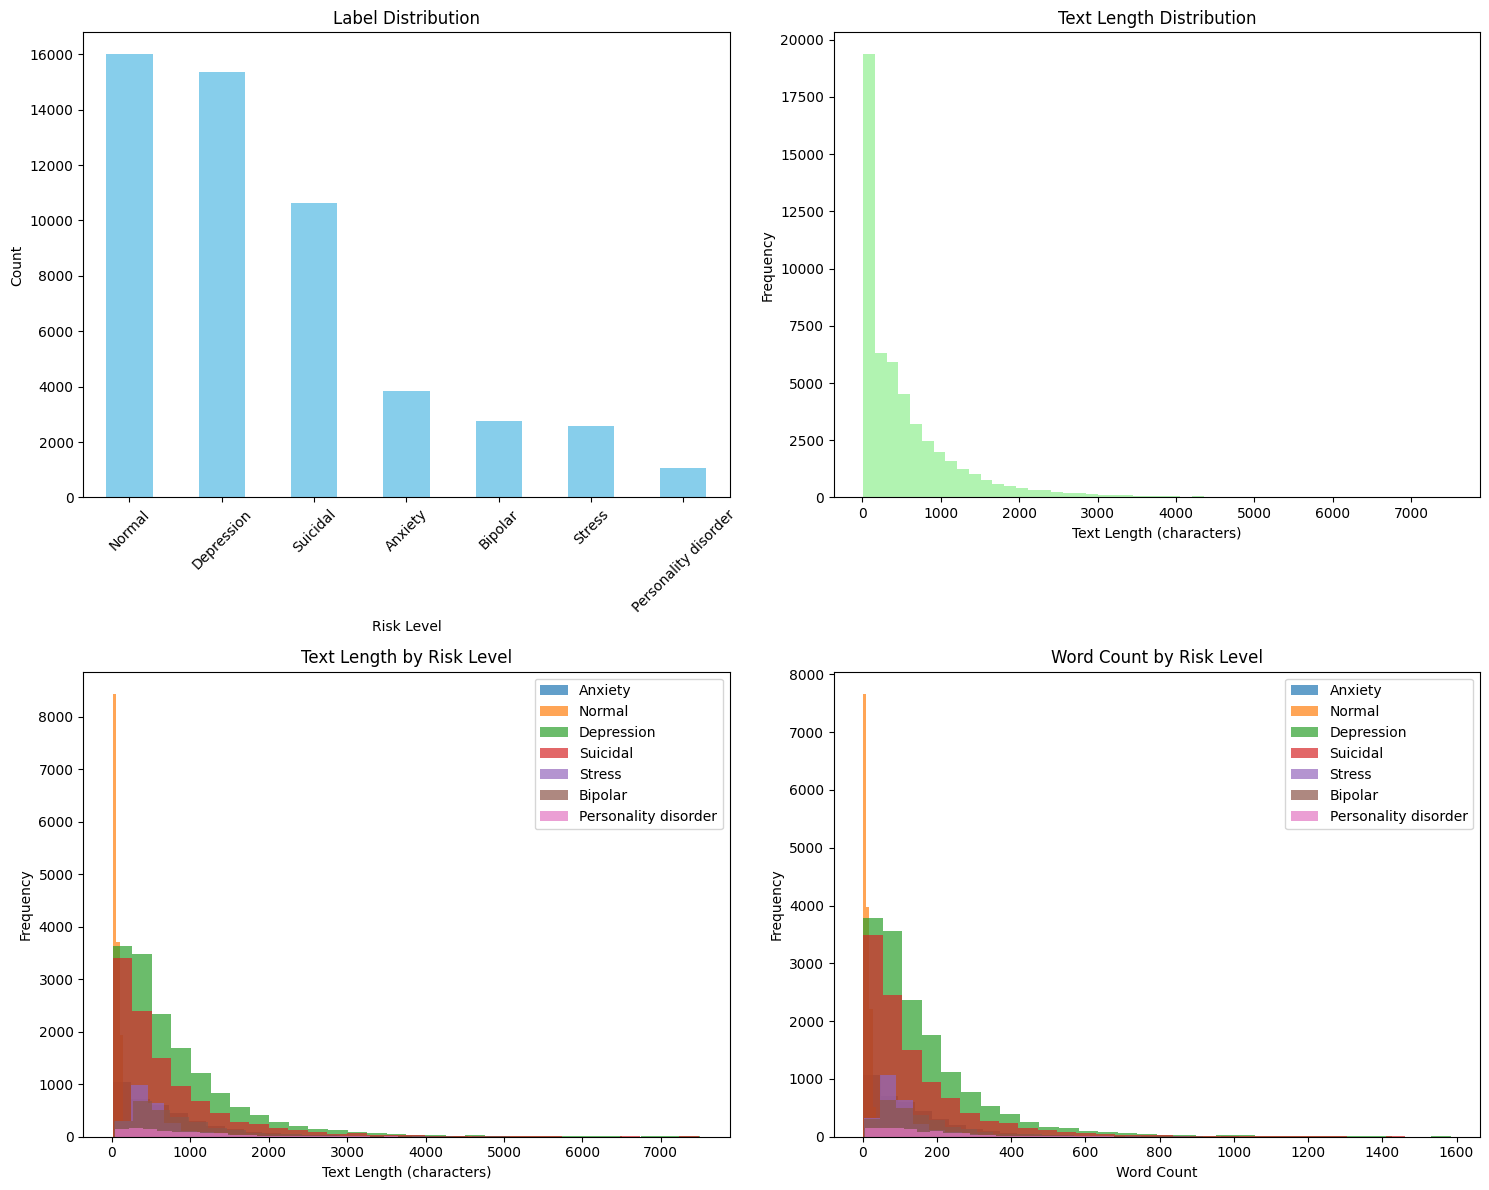

In [30]:
# Install dependencies as needed:
# !pip install kagglehub[pandas-datasets] # Uncomment if not already installed
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd # Ensure pandas is imported for DataFrame operations
#load the available datasetsfrom keggle
dataset_handle = "suchintikasarkar/sentiment-analysis-for-mental-health"

# Set the path to the file you'd like to load
# We are now specifying 'Combined Data.csv' directly
file_path = "Combined Data.csv"

# Load the latest version
df_raw_kaggle = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "suchintikasarkar/sentiment-analysis-for-mental-health",
  file_path
)

print("✅ Data loaded successfully from KaggleHub!")
print("First 5 records:")
print(df_raw_kaggle.head())

# Now, let's process this loaded data with your existing functions
df = detect_and_standardize_columns(df_raw_kaggle)
df_clean = clean_and_explore_data(df)


# 2. DATA CLEANING AND EXPLORATION


🧹 CLEANING AND EXPLORING DATA
📋 Missing Values Before Cleaning:
text    362
dtype: int64
✅ Removed 362 rows with missing/empty text
📊 Label distribution before cleaning:
label
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
📊 Label distribution after cleaning:
label
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
Percentages:
label
Normal                  31.02
Depression              29.24
Suicidal                20.22
Anxiety                  7.29
Bipolar                  5.27
Stress                   4.91
Personality disorder     2.04
Name: count, dtype: float64

📝 Text Statistics:
Average text length: 578.7 char

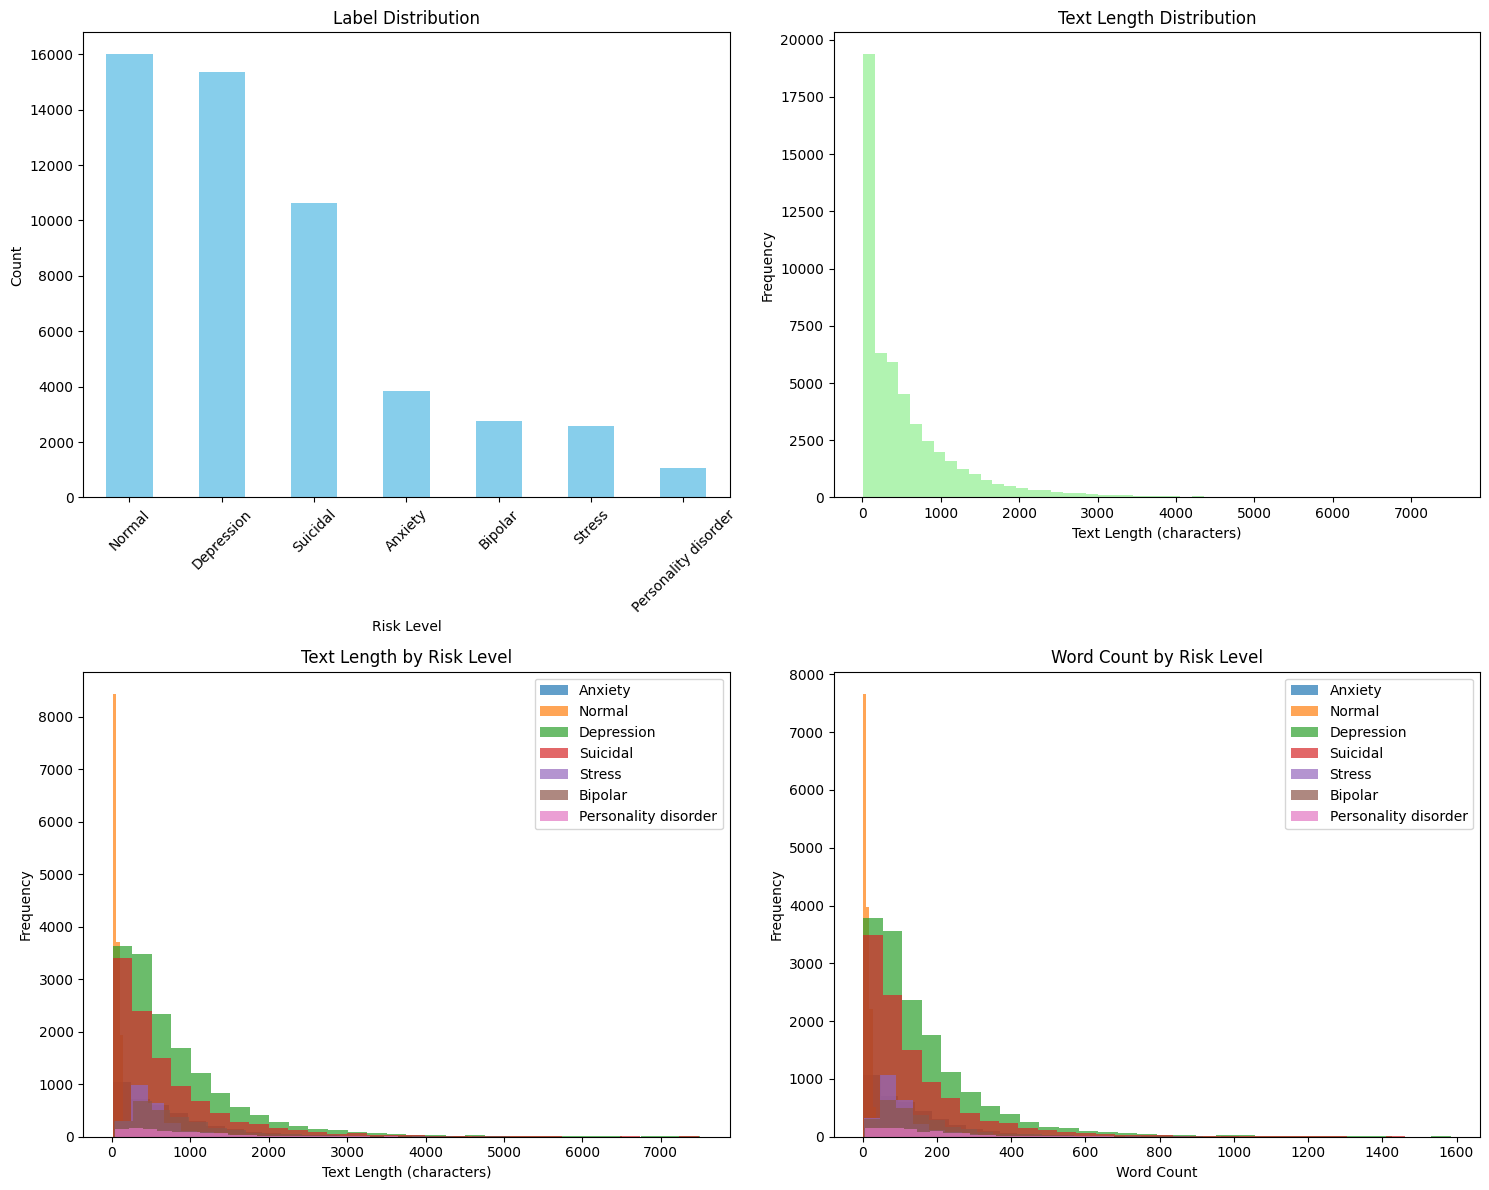

In [34]:
def clean_and_explore_data(df):
    """
    Clean data and perform exploratory data analysis
    """
    print("\n🧹 CLEANING AND EXPLORING DATA")
    print("=" * 50)

    # Handle missing values
    print("📋 Missing Values Before Cleaning:")
    missing_before = df.isnull().sum()
    print(missing_before[missing_before > 0])

    # Clean text column
    if 'text' in df.columns:
        # Remove rows with missing text
        df = df.dropna(subset=['text'])

        # Remove empty strings
        df = df[df['text'].str.strip() != '']

        # Convert to string and clean
        df['text'] = df['text'].astype(str)

        print(f"✅ Removed {len(df_raw) - len(df)} rows with missing/empty text")

    # Handle missing labels
    if 'label' in df.columns:
        print(f"📊 Label distribution before cleaning:")
        print(df['label'].value_counts())

        # Remove rows with missing labels
        df = df.dropna(subset=['label'])

        print(f"📊 Label distribution after cleaning:")
        print(df['label'].value_counts())
        print(f"Percentages:")
        print((df['label'].value_counts() / len(df) * 100).round(2))

    # Basic text statistics
    if 'text' in df.columns:
        df['text_length'] = df['text'].str.len()
        df['word_count'] = df['text'].str.split().str.len()

        print(f"\n📝 Text Statistics:")
        print(f"Average text length: {df['text_length'].mean():.1f} characters")
        print(f"Average word count: {df['word_count'].mean():.1f} words")
        print(f"Median text length: {df['text_length'].median():.1f} characters")
        print(f"Median word count: {df['word_count'].median():.1f} words")

        # Remove extremely short texts (less than 10 characters)
        short_texts = df['text_length'] < 10
        if short_texts.sum() > 0:
            print(f"⚠️  Removing {short_texts.sum()} extremely short texts")
            df = df[~short_texts]

        # Remove extremely long texts (outliers)
        q99 = df['text_length'].quantile(0.99)
        long_texts = df['text_length'] > q99 * 2
        if long_texts.sum() > 0:
            print(f"⚠️  Removing {long_texts.sum()} extremely long texts (outliers)")
            df = df[~long_texts]

    print(f"\n✅ Final dataset shape: {df.shape}")

    # Create visualizations
    if 'text' in df.columns and 'label' in df.columns:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Label distribution
        label_counts = df['label'].value_counts()
        label_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Label Distribution')
        axes[0,0].set_xlabel('Risk Level')
        axes[0,0].set_ylabel('Count')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Text length distribution
        axes[0,1].hist(df['text_length'], bins=50, alpha=0.7, color='lightgreen')
        axes[0,1].set_title('Text Length Distribution')
        axes[0,1].set_xlabel('Text Length (characters)')
        axes[0,1].set_ylabel('Frequency')

        # Text length by label
        for label in df['label'].unique():
            if pd.notna(label):
                subset = df[df['label'] == label]['text_length']
                axes[1,0].hist(subset, alpha=0.7, label=str(label), bins=30)
        axes[1,0].set_title('Text Length by Risk Level')
        axes[1,0].set_xlabel('Text Length (characters)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()

        # Word count by label
        for label in df['label'].unique():
            if pd.notna(label):
                subset = df[df['label'] == label]['word_count']
                axes[1,1].hist(subset, alpha=0.7, label=str(label), bins=30)
        axes[1,1].set_title('Word Count by Risk Level')
        axes[1,1].set_xlabel('Word Count')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()

        plt.tight_layout()
        plt.show()

    return df

# Clean and explore the data
if df is not None:
    df_clean = clean_and_explore_data(df)
else:
    print("❌ No data to clean. Please check dataset loading.")

# 3. SIMPLIFIED FEATURE ENGINEERING

In [35]:
class SimpleTextPreprocessor:
    """
    Simplified text preprocessing that's more robust
    """

    def __init__(self):
        try:
            self.sia = SentimentIntensityAnalyzer()
        except:
            print("⚠️  VADER not available, using TextBlob only")
            self.sia = None

        try:
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words = set(stopwords.words('english'))
        except:
            print("⚠️  NLTK resources not fully available, using basic preprocessing")
            self.lemmatizer = None
            self.stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

        # Mental health keywords
        self.risk_keywords = [
            'depression', 'depressed', 'suicide', 'suicidal', 'anxiety', 'anxious',
            'panic', 'hopeless', 'worthless', 'kill myself', 'end it all',
            'can\'t take it', 'want to die', 'self harm', 'cut myself',
            'lonely', 'isolated', 'no friends', 'nobody cares'
        ]

        self.positive_keywords = [
            'happy', 'joy', 'grateful', 'blessed', 'excited', 'love',
            'amazing', 'wonderful', 'great', 'fantastic', 'positive'
        ]

    def extract_basic_features(self, text):
        """
        Extract basic features that don't rely on complex NLP
        """
        if pd.isna(text) or text == "":
            return {
                'text_length': 0,
                'word_count': 0,
                'exclamation_count': 0,
                'question_count': 0,
                'caps_ratio': 0,
                'risk_keywords_count': 0,
                'positive_keywords_count': 0,
                'textblob_polarity': 0,
                'vader_compound': 0
            }

        text_str = str(text)
        text_lower = text_str.lower()

        # Basic counts
        text_length = len(text_str)
        word_count = len(text_str.split())
        exclamation_count = text_str.count('!')
        question_count = text_str.count('?')

        # Caps ratio
        caps_count = sum(1 for char in text_str if char.isupper())
        caps_ratio = caps_count / text_length if text_length > 0 else 0

        # Keyword counts
        risk_count = sum(1 for keyword in self.risk_keywords if keyword in text_lower)
        positive_count = sum(1 for keyword in self.positive_keywords if keyword in text_lower)

        # Sentiment scores
        try:
            blob = TextBlob(text_str)
            textblob_polarity = blob.sentiment.polarity
        except:
            textblob_polarity = 0

        vader_compound = 0
        if self.sia:
            try:
                scores = self.sia.polarity_scores(text_str)
                vader_compound = scores['compound']
            except:
                pass

        return {
            'text_length': text_length,
            'word_count': word_count,
            'exclamation_count': exclamation_count,
            'question_count': question_count,
            'caps_ratio': caps_ratio,
            'risk_keywords_count': risk_count,
            'positive_keywords_count': positive_count,
            'textblob_polarity': textblob_polarity,
            'vader_compound': vader_compound
        }

    def simple_text_clean(self, text):
        """
        Simple text cleaning
        """
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

# Apply feature engineering
if 'df_clean' in locals() and df_clean is not None:
    print("\n🔧 Extracting features...")

    preprocessor = SimpleTextPreprocessor()

    # Extract features
    feature_list = []
    for idx, text in df_clean['text'].items():
        features = preprocessor.extract_basic_features(text)
        feature_list.append(features)

    # Create feature DataFrame
    feature_df = pd.DataFrame(feature_list, index=df_clean.index)

    # Combine with original data
    df_features = pd.concat([df_clean, feature_df], axis=1)

    # Clean text for TF-IDF
    df_features['cleaned_text'] = df_features['text'].apply(preprocessor.simple_text_clean)

    print("✅ Feature extraction completed!")
    print(f"📊 Feature columns added: {list(feature_df.columns)}")

    # Show feature summary
    print(f"\nFeature Summary:")
    print(feature_df.describe())


🔧 Extracting features...
✅ Feature extraction completed!
📊 Feature columns added: ['text_length', 'word_count', 'exclamation_count', 'question_count', 'caps_ratio', 'risk_keywords_count', 'positive_keywords_count', 'textblob_polarity', 'vader_compound']

Feature Summary:
        text_length    word_count  exclamation_count  question_count  \
count  52266.000000  52266.000000       52266.000000    52266.000000   
mean     572.331917    112.026614           0.138159        0.587571   
std      756.975357    147.923775           0.792959        1.274162   
min       10.000000      1.000000           0.000000        0.000000   
25%       82.000000     16.000000           0.000000        0.000000   
50%      320.000000     63.000000           0.000000        0.000000   
75%      755.000000    149.000000           0.000000        1.000000   
max     7502.000000   1584.000000          58.000000       39.000000   

         caps_ratio  risk_keywords_count  positive_keywords_count  \
count  52

# 4. SIMPLIFIED MACHINE LEARNING PIPELINE

🎯 Preparing data for machine learning...
📝 TF-IDF features: 1000
📊 Available labels: label
Normal                  15993
Depression              15364
Suicidal                10639
Anxiety                  3836
Bipolar                  2774
Stress                   2584
Personality disorder     1076
Name: count, dtype: int64
🎯 Binary labels - High risk: 36273, Low risk: 15993
✅ Final feature matrix shape: (52266, 1011)
🚀 Training models with carbon emission tracking...


[codecarbon WARNING @ 02:05:48] Multiple instances of codecarbon are allowed to run at the same time.


🔄 Training Logistic Regression...


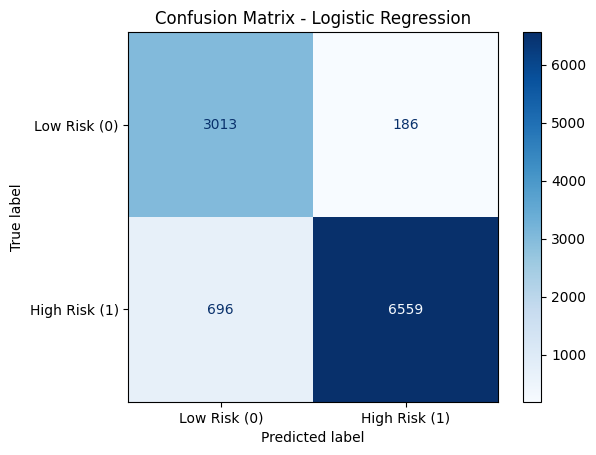

✅ Logistic Regression - Accuracy: 0.9156, ROC AUC: 0.9776, Time: 122.48s, CO₂: 0.000510 kg
🔄 Training Random Forest...


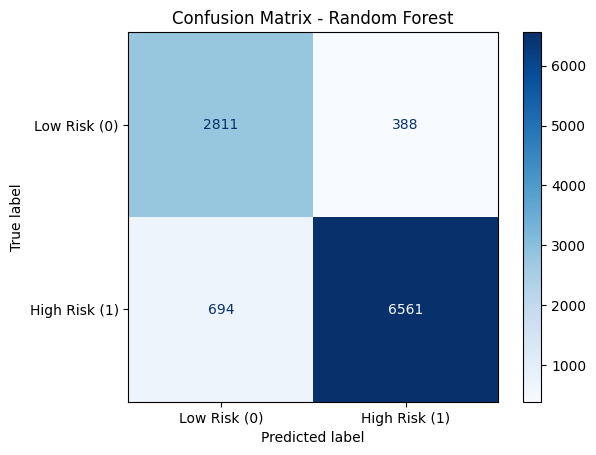

✅ Random Forest - Accuracy: 0.8965, ROC AUC: 0.9670, Time: 8.48s, CO₂: 0.000035 kg
🔄 Training Gradient Boosting...


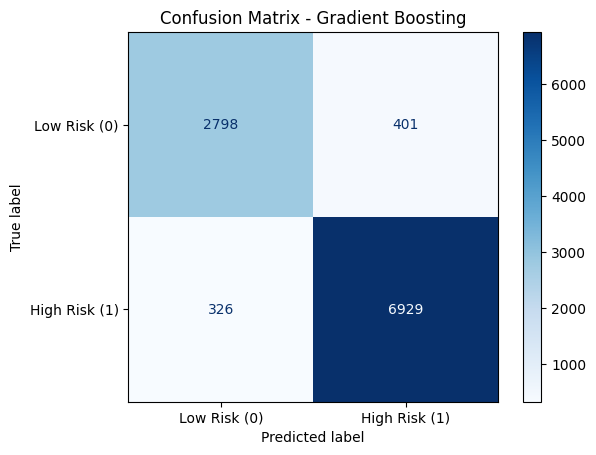

✅ Gradient Boosting - Accuracy: 0.9305, ROC AUC: 0.9769, Time: 281.20s, CO₂: 0.001171 kg
🔄 Training Linear SVM...


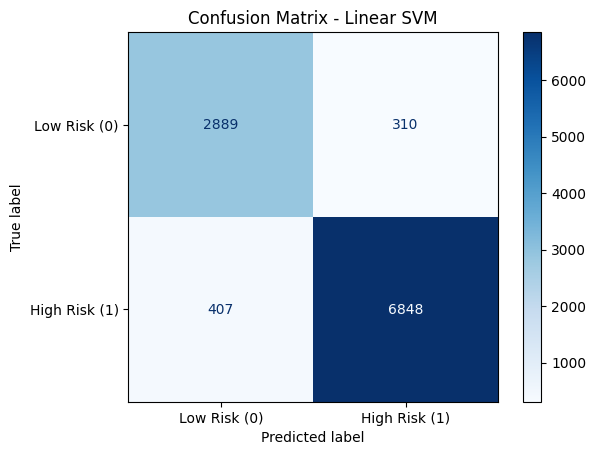

✅ Linear SVM - Accuracy: 0.9314, ROC AUC: 0.9785, Time: 6.53s, CO₂: 0.000027 kg
🔄 Training Naive Bayes...


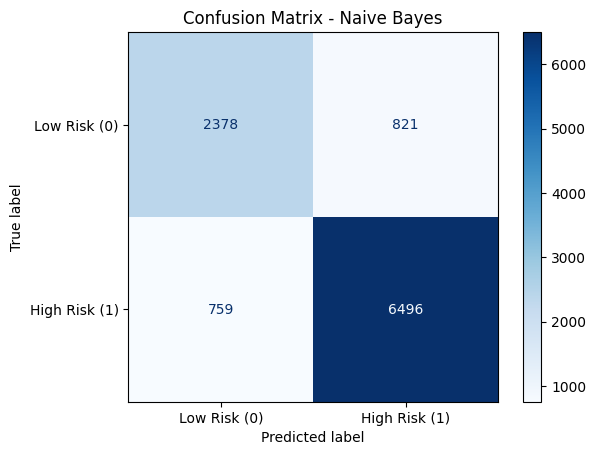

✅ Naive Bayes - Accuracy: 0.8489, ROC AUC: 0.9194, Time: 0.47s, CO₂: 0.000002 kg
🔄 Training Neural Network...


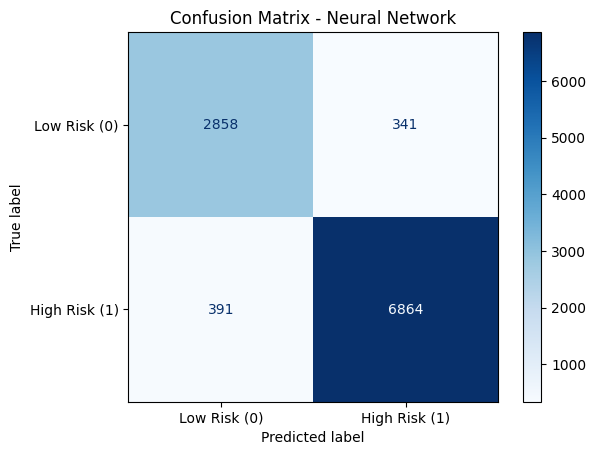

✅ Neural Network - Accuracy: 0.9300, ROC AUC: 0.9741, Time: 39.17s, CO₂: 0.000163 kg

📊 COMPREHENSIVE RESULTS TABLE
          Algorithm Accuracy Precision Recall F1 Score ROC AUC Training Time (s) CO₂ Emission (kg)
Logistic Regression    91.6%     0.972  0.904    0.937   0.978             122.5          0.000510
      Random Forest    89.6%     0.944  0.904    0.924   0.967               8.5          0.000035
  Gradient Boosting    93.0%     0.945  0.955    0.950   0.977             281.2          0.001171
         Linear SVM    93.1%     0.957  0.944    0.950   0.978               6.5          0.000027
        Naive Bayes    84.9%     0.888  0.895    0.892   0.919               0.5          0.000002
     Neural Network    93.0%     0.953  0.946    0.949   0.974              39.2          0.000163


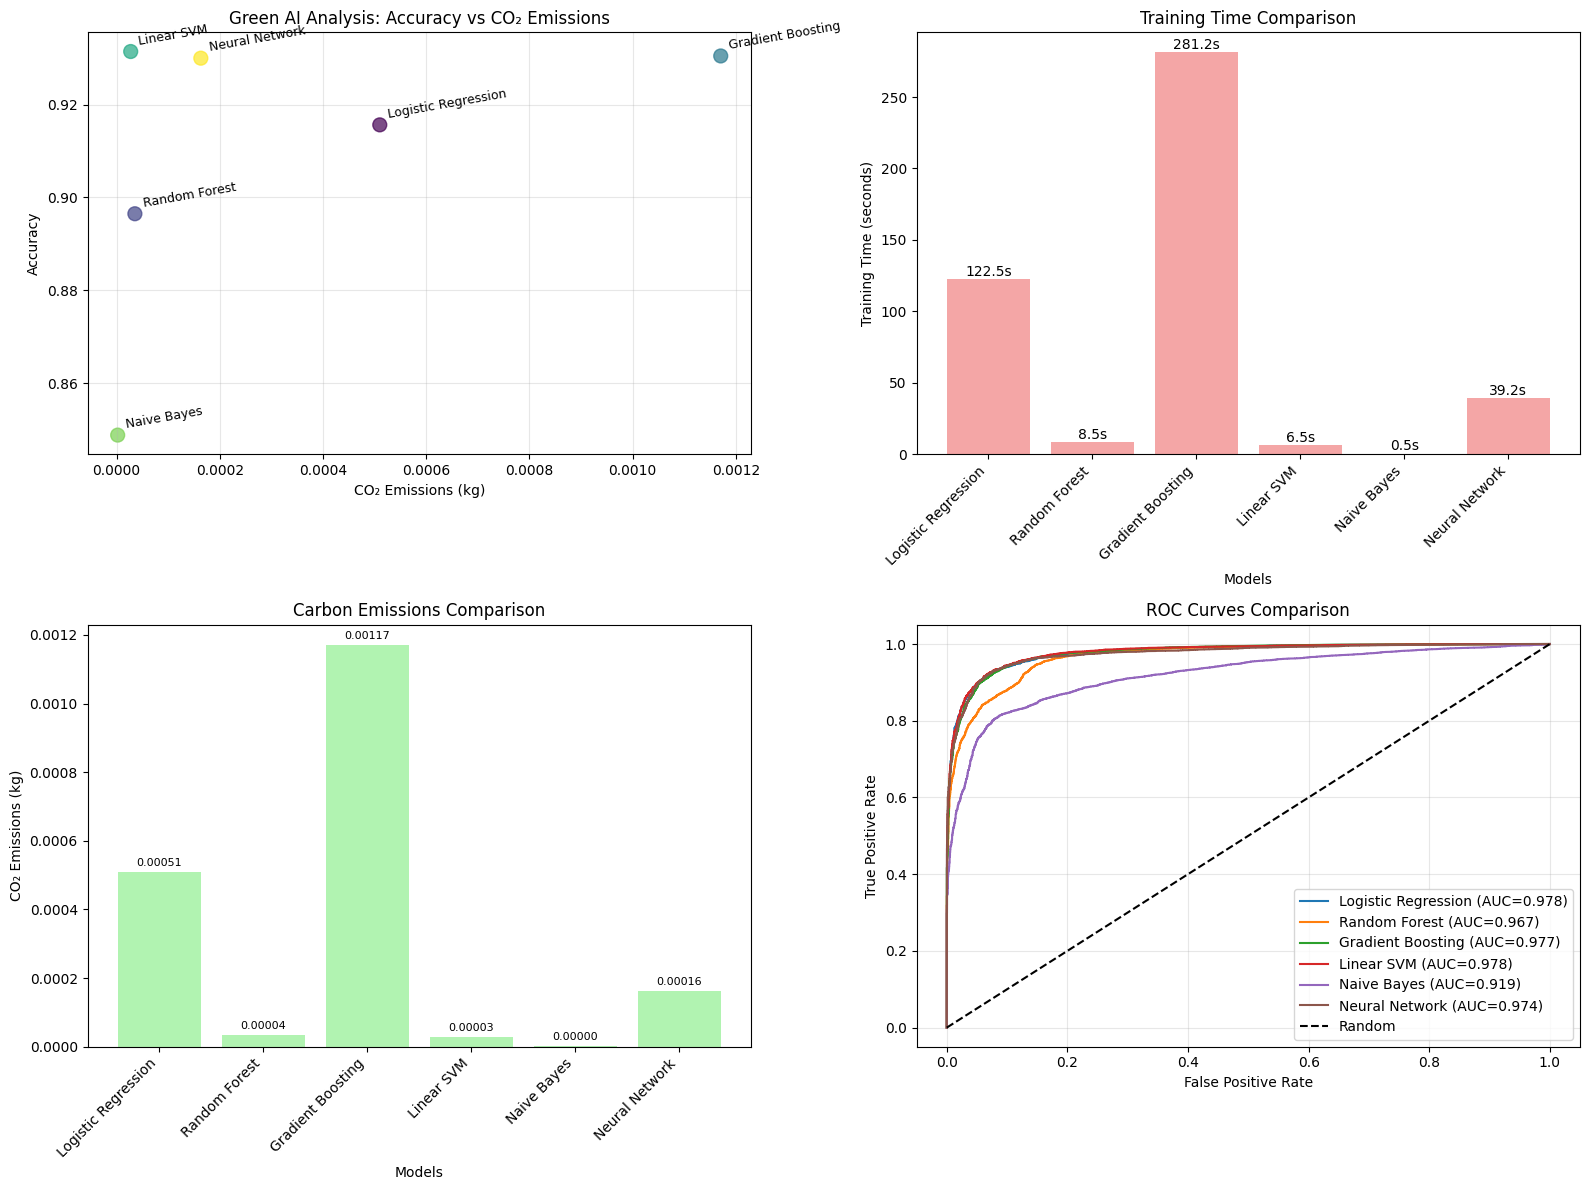


🌱 GREEN AI RECOMMENDATION
🏆 Most Efficient Model (Best Accuracy/Emission Ratio): Naive Bayes
🎯 Highest Accuracy Model: Linear SVM
🌿 Lowest Emissions Model: Naive Bayes
⚡ Fastest Training Model: Naive Bayes

💡 GREEN AI RECOMMENDATION:
⚖️ TRADE-OFF DECISION:
   - Use Naive Bayes for production (most efficient)
   - Use Linear SVM for research (highest accuracy)
   - Accuracy difference: 0.083

📈 DETAILED COMPARISON:

Naive Bayes:
  Accuracy: 0.8489
  Training Time: 0.47s
  CO₂ Emissions: 0.000002 kg
  Efficiency Score: 432338

Linear SVM:
  Accuracy: 0.9314
  Training Time: 6.53s
  CO₂ Emissions: 0.000027 kg
  Efficiency Score: 34254

🎉 ANALYSIS COMPLETED SUCCESSFULLY!


In [29]:
class MentalHealthPredictorWithCarbon:
    """Complete ML pipeline with carbon emission tracking"""

    def __init__(self):
        self.models = {}
        self.vectorizer = None
        self.scaler = StandardScaler()
        self.results = {}

    def prepare_data(self, df_features):
        """Prepare data for ML models"""
        print("🎯 Preparing data for machine learning...")

        # Select numerical features
        feature_cols = ['text_length', 'word_count', 'exclamation_count', 'question_count',
                       'caps_ratio', 'risk_keywords_count', 'positive_keywords_count',
                       'textblob_polarity', 'vader_compound']

        # TF-IDF vectorization
        self.vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 1),
            stop_words='english',
            min_df=2,
            max_df=0.9
        )

        try:
            text_vectors = self.vectorizer.fit_transform(df_features['cleaned_text'].fillna(''))
            print(f"📝 TF-IDF features: {text_vectors.shape[1]}")
        except:
            print("⚠️  TF-IDF failed, using only numerical features")
            text_vectors = np.zeros((len(df_features), 0))

        # Prepare numerical features
        numerical_data = df_features[feature_cols].fillna(0)

        # Combine features
        if text_vectors.shape[1] > 0:
            X = np.hstack([text_vectors.toarray(), numerical_data.values])
        else:
            X = numerical_data.values

        # Prepare binary labels
        if 'label' in df_features.columns:
            y = df_features['label'].fillna('unknown')
            print(f"📊 Available labels: {y.value_counts()}")

            # Create binary classification
            high_risk_labels = ['depression', 'suicidal', 'anxiety', 'bipolar', 'stress', 'personality disorder']
            y_binary = y.apply(lambda x: 1 if str(x).lower() in high_risk_labels else 0)

            print(f"🎯 Binary labels - High risk: {sum(y_binary)}, Low risk: {len(y_binary) - sum(y_binary)}")
        else:
            print("❌ No label column found")
            return None, None

        print(f"✅ Final feature matrix shape: {X.shape}")
        return X, y_binary

    def train_models_with_carbon_tracking(self, X, y):
        """Train models with carbon emission tracking"""
        print("🚀 Training models with carbon emission tracking...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Define models
        linear_svc = LinearSVC(class_weight="balanced", random_state=42, max_iter=1000)
        svc_calibrated = CalibratedClassifierCV(linear_svc)

        self.models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
            'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, class_weight='balanced'),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42, max_depth=6),
            'Linear SVM': svc_calibrated,
            'Naive Bayes': MultinomialNB(alpha=1.0),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True)
        }

        # Train models with carbon tracking
        for name, model in self.models.items():
            try:
                print(f"🔄 Training {name}...")

                # Start carbon tracking
                tracker = EmissionsTracker(
                    project_name=f"Mental_Health_{name.replace(' ', '_')}",
                    log_level='error'  # Reduce console output
                )
                tracker.start()
                start_time = time.time()

                # Train model with appropriate preprocessing
                if name == 'Naive Bayes':
                    X_train_nb = np.abs(X_train) + 1e-6
                    X_test_nb = np.abs(X_test) + 1e-6
                    model.fit(X_train_nb, y_train)
                    y_pred = model.predict(X_test_nb)
                    y_pred_proba = model.predict_proba(X_test_nb)[:, 1]

                elif name == 'Neural Network':
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred_proba = model.predict_proba(X_test)[:, 1]

                # Stop tracking
                training_time = time.time() - start_time
                emissions = tracker.stop()

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                f1 = f1_score(y_test, y_pred)

                # ✅ Confusion Matrix
                cm = confusion_matrix(y_test, y_pred)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk (0)', 'High Risk (1)'])
                disp.plot(cmap=plt.cm.Blues, values_format='d')
                plt.title(f"Confusion Matrix - {name}")
                plt.show()

                # Store results
                self.results[name] = {
                    'model': model,
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba,
                    'accuracy': accuracy,
                    'roc_auc': roc_auc,
                    'f1_score': f1,
                    'training_time': training_time,
                    'co2_emissions': emissions if emissions else 0.000001  # Avoid zero division
                }

                print(f"✅ {name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}, Time: {training_time:.2f}s, CO₂: {emissions:.6f} kg")

            except Exception as e:
                print(f"❌ Error training {name}: {str(e)}")
                continue

        return X_test, y_test

    def create_results_table(self):
        """Create comprehensive results table with Precision & Recall"""
        if not self.results:
            print("❌ No results available")
            return None

        results_data = []
        for name, result in self.results.items():
            precision = precision_score(result['y_test'], result['y_pred'])
            recall = recall_score(result['y_test'], result['y_pred'])
            results_data.append({
                'Algorithm': name,
                'Accuracy': f"{result['accuracy']:.1%}",
                'Precision': f"{precision:.3f}",
                'Recall': f"{recall:.3f}",
                'F1 Score': f"{result['f1_score']:.3f}",
                'ROC AUC': f"{result['roc_auc']:.3f}",
                'Training Time (s)': f"{result['training_time']:.1f}",
                'CO₂ Emission (kg)': f"{result['co2_emissions']:.6f}"
            })

        results_df = pd.DataFrame(results_data)
        print("\n📊 COMPREHENSIVE RESULTS TABLE")
        print("=" * 100)
        print(results_df.to_string(index=False))

        return results_df

    def create_green_ai_visualization(self):
        """Create Green AI analysis visualizations"""
        if not self.results:
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        models = list(self.results.keys())
        accuracies = [self.results[name]['accuracy'] for name in models]
        emissions = [self.results[name]['co2_emissions'] for name in models]
        training_times = [self.results[name]['training_time'] for name in models]
        roc_aucs = [self.results[name]['roc_auc'] for name in models]

        # 1. Accuracy vs CO₂ Emissions scatter plot
        scatter = ax1.scatter(emissions, accuracies, s=100, alpha=0.7, c=range(len(models)), cmap='viridis')
        for i, model in enumerate(models):
            ax1.annotate(model, (emissions[i], accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9, rotation=10)

        ax1.set_xlabel('CO₂ Emissions (kg)')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Green AI Analysis: Accuracy vs CO₂ Emissions')
        ax1.grid(True, alpha=0.3)

        # 2. Training time comparison
        bars = ax2.bar(range(len(models)), training_times, alpha=0.7, color='lightcoral')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('Training Time Comparison')
        ax2.set_xticks(range(len(models)))
        ax2.set_xticklabels(models, rotation=45, ha='right')

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}s', ha='center', va='bottom')

        # 3. CO₂ emissions comparison
        bars = ax3.bar(range(len(models)), emissions, alpha=0.7, color='lightgreen')
        ax3.set_xlabel('Models')
        ax3.set_ylabel('CO₂ Emissions (kg)')
        ax3.set_title('Carbon Emissions Comparison')
        ax3.set_xticks(range(len(models)))
        ax3.set_xticklabels(models, rotation=45, ha='right')

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(emissions)*0.01,
                    f'{height:.5f}', ha='center', va='bottom', fontsize=8)

        # 4. ROC Curves
        for name, result in self.results.items():
            fpr, tpr, _ = roc_curve(result['y_test'], result['y_pred_proba'])
            ax4.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")

        ax4.plot([0, 1], [0, 1], 'k--', label='Random')
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curves Comparison')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def green_ai_recommendation(self):
        """Provide Green AI recommendation without duplicates"""
        if not self.results:
            return

        print("\n🌱 GREEN AI RECOMMENDATION")
        print("=" * 50)

        # Calculate efficiency scores
        efficiency_scores = {}
        for name, result in self.results.items():
            if result['co2_emissions'] > 0:
                efficiency_scores[name] = result['accuracy'] / result['co2_emissions']
            else:
                efficiency_scores[name] = result['accuracy'] / 0.000001

        # Identify key models
        most_efficient = max(efficiency_scores.keys(), key=lambda x: efficiency_scores[x])
        highest_accuracy = max(self.results.keys(), key=lambda x: self.results[x]['accuracy'])
        lowest_emissions = min(self.results.keys(), key=lambda x: self.results[x]['co2_emissions'])
        fastest_training = min(self.results.keys(), key=lambda x: self.results[x]['training_time'])

        print(f"🏆 Most Efficient Model (Best Accuracy/Emission Ratio): {most_efficient}")
        print(f"🎯 Highest Accuracy Model: {highest_accuracy}")
        print(f"🌿 Lowest Emissions Model: {lowest_emissions}")
        print(f"⚡ Fastest Training Model: {fastest_training}")

        print(f"\n💡 GREEN AI RECOMMENDATION:")
        if most_efficient == highest_accuracy:
            print(f"✅ RECOMMENDED: {most_efficient}")
            print("   - Provides both high accuracy and efficiency")
            print("   - Optimal balance of performance and sustainability")
        else:
            acc_diff = self.results[highest_accuracy]['accuracy'] - self.results[most_efficient]['accuracy']
            if acc_diff < 0.05:
                print(f"✅ RECOMMENDED: {most_efficient}")
                print(f"   - Similar accuracy ({acc_diff:.3f} difference) with much better efficiency")
                print("   - Best choice for sustainable deployment")
            else:
                print(f"⚖️ TRADE-OFF DECISION:")
                print(f"   - Use {most_efficient} for production (most efficient)")
                print(f"   - Use {highest_accuracy} for research (highest accuracy)")
                print(f"   - Accuracy difference: {acc_diff:.3f}")

        # Show detailed comparison (no duplicates)
        print(f"\n📈 DETAILED COMPARISON:")
        printed_models = set()  # track models already printed
        for model in [most_efficient, highest_accuracy, lowest_emissions, fastest_training]:
            if model not in printed_models:
                result = self.results[model]
                print(f"\n{model}:")
                print(f"  Accuracy: {result['accuracy']:.4f}")
                print(f"  Training Time: {result['training_time']:.2f}s")
                print(f"  CO₂ Emissions: {result['co2_emissions']:.6f} kg")
                print(f"  Efficiency Score: {efficiency_scores[model]:.0f}")
                printed_models.add(model)


# Run the complete pipeline
if 'df_features' in locals() and df_features is not None:
    predictor = MentalHealthPredictorWithCarbon()

    # Prepare data
    X, y = predictor.prepare_data(df_features)

    if X is not None and y is not None:
        # Train models with carbon tracking
        X_test, y_test = predictor.train_models_with_carbon_tracking(X, y)

        # Create comprehensive results table
        results_df = predictor.create_results_table()

        # Create Green AI visualizations
        predictor.create_green_ai_visualization()

        # Provide Green AI recommendation
        predictor.green_ai_recommendation()

        print("\n🎉 ANALYSIS COMPLETED SUCCESSFULLY!")

    else:
        print("❌ Could not prepare data for machine learning")
else:
    print("❌ Feature extraction failed - please check the data processing steps")